In [52]:
import math
import warnings

from IPython.display import display
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model
from sklearn.preprocessing import quantile_transform
from sklearn import preprocessing
import statsmodels.formula.api as smf
from scipy import stats
from array import array
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
warnings.filterwarnings(
    action="ignore",
    module="scipy",
    message="^internal gelsd"
)

## The Extraordinary Power of Explanatory Power

The strength of multiple linear regression lies in its ability to provide straightforward and interpretable solutions that not only predict future outcomes, but also provide insight into the underlying processes that create these outcomes.  For example, after fitting the following model:

$$HourlyWidgetProduction = \alpha + \beta_1WorkerAgeFrom18+ \beta_2WorkerYearsinJob + \beta_3IsRoundWidget$$

we get these parameters:
$$\alpha = 2$$
$$\beta_1 = .1$$
$$\beta_2 = .2$$
$$\beta_3 = 4$$

Using those parameters, we learn that round widgets are twice as fast to produce as non-round widgets. We can tell because $\alpha$ represents the intercept, the hourly rate of production for widgets that are not round (2 an hour) and $\beta_3$ represents the difference between the intercept and the hourly rate of production for round widgets (also 2 an hour, for a total of 4 round widgets an hour).

We also learn that for every year a worker ages after the age of 18, their hourly production-rate goes up by .1 ($\beta_1$).  In addition, for every year a worker has been in that job, their hourly production-rate goes up by .2 ($\beta_2$).  

Furthermore, using this model, we can predict that a 20-year-old worker who has been in the job for a year and is making only round widgets will make $2 + .1*2 + .2*1 + 4 = 6.3$ round widgets an hour.

Finally, and probably of greatest interest, we get an **R-Squared** value.  This is a proportion (between 0 and 1) that expresses how much variance in the outcome variable our model was able to explain.  Higher $R^2$ values are better to a point-- a low $R^2$ indicates that our model isn't explaining much information about the outcome, which means it will not give very good predictions.  However, a very high $R^2$ is a warning sign for overfitting.  No dataset is a perfect representation of reality, so a model that perfectly fits our data ($R^2$ of 1 or close to 1) is likely to be biased by quirks in the data, and will perform less well on the test-set.

Here's an example using a toy advertising dataset:


In [53]:
# Acquire, load, and preview the data.
data = pd.read_csv('https://tf-curricula-prod.s3.amazonaws.com/data-science/Advertising.csv')
display(data.head())

# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = data['Sales'].values.reshape(-1, 1)
X = data[['TV','Radio','Newspaper']]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))

,Unnamed: 0,TV,Radio,Newspaper,Sales
0,1,230.100,37.800,69.200,22.100
1,2,44.500,39.300,45.100,10.400
2,3,17.200,45.900,69.300,9.300
3,4,151.500,41.300,58.500,18.500
4,5,180.800,10.800,58.400,12.900



Coefficients: 
 [[ 0.04576465  0.18853002 -0.00103749]]

Intercept: 
 [2.93888937]

R-squared:
0.8972106381789521


The model where the outcome Sales is predicted by the features TV, Radio, and Newspaper explains 89.7% of the variance in Sales.  Note that we don't know from these results how much of that variance is explained by each of the three features.  Looking at the coefficients, there appears to be a base rate of Sales that happen even with no ads in any medium (intercept: 2.939) and sales have the highest per-unit increase when ads are on the radio (0.189).  

## Assumptions of Multivariable Linear Regression

For regression to work its magic, inputs to the model need to be consistent with four assumptions:


### Assumption one: linear relationship

As mentioned earlier, features in a regression need to have a linear relationship with the outcome.  If the relationship is non-linear, the regression model will try to find any hint of a linear relationship, and only explain that – with predictable consequences for the validity of the model.

Sometimes this can be fixed by applying a non-linear transformation function to a feature.  For example, if the relationship between feature and outcome is quadratic and all feature scores are > 0, we can take the square root of the features, resulting in a linear relationship between the outcome and sqrt(feature).  


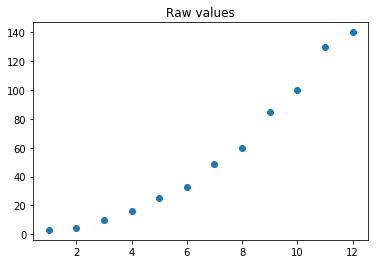

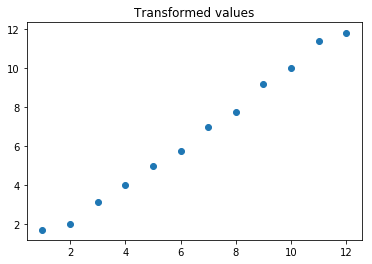

In [54]:
# Sample data.
outcome = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
feature = [3, 4, 10, 16, 25, 33, 49, 60, 85, 100, 130, 140]

# Plot the data as-is. Looks a mite quadratic.
plt.scatter(outcome, feature)
plt.title('Raw values')
plt.show()

# Create a feature using a non-linear transformation.
sqrt_feature = [math.sqrt(x) for x in  feature]


# Well now isn't that nice.
plt.scatter(outcome, sqrt_feature)
plt.title('Transformed values')
plt.show()

When interpreting features with non-linear transformations, it is important to keep the transformation in mind.  For example, in the equation $y = 2log({x})$, y increases by one unit for every two-unit increase in $log({x})$.  The relationship between y and x, however, is non-linear, and the amount of change in y varies based on the absolute value of x:

|x	|log(x)|	y|
|--|--|--|
|1	|0	|0|
|10	|1	|2|
|100	|2	|4|	
|1000|	3	|6|

So a one-unit change in x from 1 to 2 will result in a much greater change in y than a one-unit change in x from 100 to 101.

There are many variable transformations.  For a deep dive, check out the Variable Linearization section of [Fifty Ways to Fix Your Data](https://statswithcats.wordpress.com/2010/11/21/fifty-ways-to-fix-your-data/).

### Assumption two: multivariate normality

The error from the model (calculated by subtracting the model-predicted values from the real outcome values) should be normally distributed.  Since ordinary least squares regression models are fitted by choosing the parameters that best minimize error, skewness or outliers in the error can result in serious miss-estimations.

Outliers or skewness in error can often be traced back to outliers or skewness in data.  

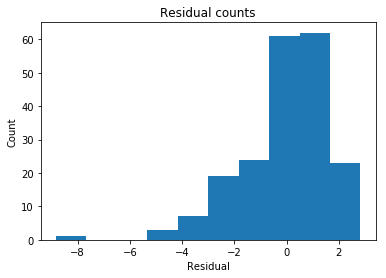

In [55]:
# Extract predicted values.
predicted = regr.predict(X).ravel()
actual = data['Sales']

# Calculate the error, also called the residual.
residual = actual - predicted

# This looks a bit concerning.
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()


### Assumption three: homoscedasticity

The distribution of your error terms (its "scedasticity"), should be consistent for all predicted values, or **homoscedastic**.

For example, if your error terms aren't consistently distributed and you have more variance in the error for large outcome values than for small ones, then the confidence interval for large predicted values will be too small because it will be based on the average error variance.  This leads to overconfidence in the accuracy of your model's predictions.

Some fixes to heteroscedasticity include transforming the dependent variable and adding features that target the poorly-estimated areas. For example, if a model tracks data over time and model error variance jumps in the September to November period, a binary feature indicating season may be enough to resolve the problem.

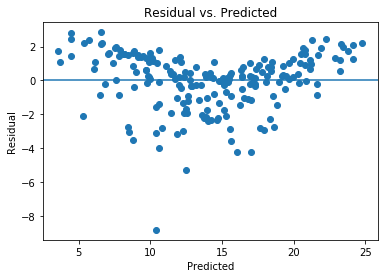

In [56]:
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

# Hm... looks a bit concerning.

### Assumption four: low multicollinearity

Correlations among features should be low or nonexistent.  When features are correlated, they may both explain the same pattern of variance in the outcome.  The model will attempt to find a solution, potentially by attributing half the explanatory power to one feature and half to the other.  This isn’t a problem if our only goal is prediction, because then all that matters is that the variance gets explained.  However, if we want to know which features matter most when predicting an outcome, multicollinearity can cause us to underestimate the relationship between features and outcomes.

Multicollinearity can be fixed by PCA or by discarding some of the correlated features.

In [57]:
correlation_matrix = X.corr()
display(correlation_matrix)

,TV,Radio,Newspaper
TV,1.000,0.055,0.057
Radio,0.055,1.000,0.354
Newspaper,0.057,0.354,1.000


## Drill: fixing assumptions

Judging from the diagnostic plots, your data has a problem with both heteroscedasticity and multivariate non-normality.  Use the cell(s) below to see what you can do to fix it.

In [58]:
# Your code here.

#Independent Variable Transformations
# methods for creating new variables from the original independent 
#variables, which have better correlations with the dependent variable.

# Sample data.
outcome = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
feature = [3, 4, 10, 16, 25, 33, 49, 60, 85, 100, 130, 140]

data.insert(0, 'Outcome', '')
data.insert(1, 'Feature', '')
data = data.drop(['Unnamed: 0'], axis=1)
data

#Sample Adjustments
#methods for fixing missing, erroneous, or unrepresentative data points.


,Outcome,Feature,TV,Radio,Newspaper,Sales
0,,,230.100,37.800,69.200,22.100
1,,,44.500,39.300,45.100,10.400
2,,,17.200,45.900,69.300,9.300
3,,,151.500,41.300,58.500,18.500
4,,,180.800,10.800,58.400,12.900
5,,,8.700,48.900,75.000,7.200
6,,,57.500,32.800,23.500,11.800
7,,,120.200,19.600,11.600,13.200
8,,,8.600,2.100,1.000,4.800
9,,,199.800,2.600,21.200,10.600


TV std:  85.8542363149081


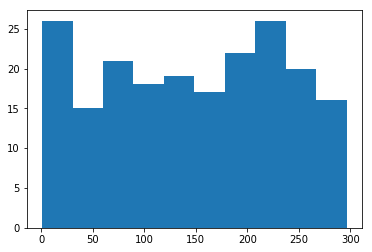

In [59]:
#Independent Variable Transformations
# methods for creating new variables from the original independent 
#variables, which have better correlations with the dependent variable.

plt.hist(data['TV'])
plt.show

print('TV std: ', data['TV'].std())

radio std:  14.846809176168723


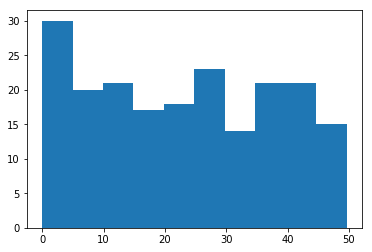

In [60]:
plt.hist(data['Radio'])
plt.show

print('radio std: ', data['Radio'].std())

<function matplotlib.pyplot.show(*args, **kw)>

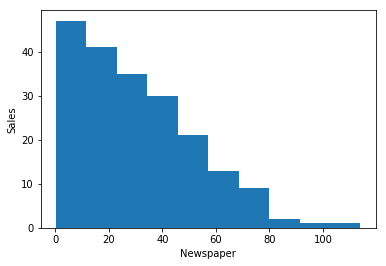

In [61]:
plt.hist(data['Newspaper'])
plt.ylabel('Sales')
plt.xlabel('Newspaper')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

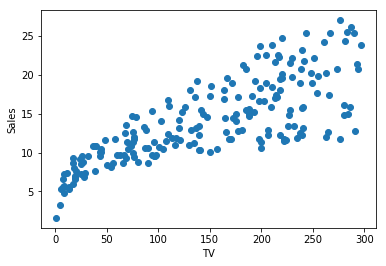

In [62]:
plt.scatter(data['TV'], data['Sales'])
plt.ylabel('Sales')
plt.xlabel('TV')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

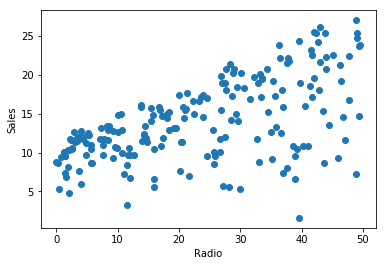

In [63]:
plt.scatter(data['Radio'], data['Sales'])
plt.ylabel('Sales')
plt.xlabel('Radio')
plt.show

In [64]:
l = data['Newspaper']
data['Newspaper transform 1'] =  np.where(data['Newspaper'] > 79, 78, l)

data

,Outcome,Feature,TV,Radio,Newspaper,Sales,Newspaper transform 1
0,,,230.100,37.800,69.200,22.100,69.200
1,,,44.500,39.300,45.100,10.400,45.100
2,,,17.200,45.900,69.300,9.300,69.300
3,,,151.500,41.300,58.500,18.500,58.500
4,,,180.800,10.800,58.400,12.900,58.400
5,,,8.700,48.900,75.000,7.200,75.000
6,,,57.500,32.800,23.500,11.800,23.500
7,,,120.200,19.600,11.600,13.200,11.600
8,,,8.600,2.100,1.000,4.800,1.000
9,,,199.800,2.600,21.200,10.600,21.200


<function matplotlib.pyplot.show(*args, **kw)>

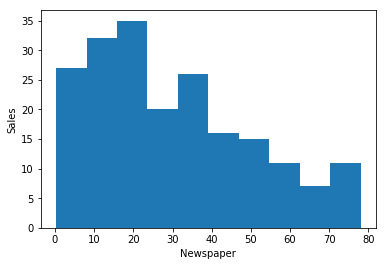

In [65]:
plt.hist(data['Newspaper transform 1'])
plt.ylabel('Sales')
plt.xlabel('Newspaper')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

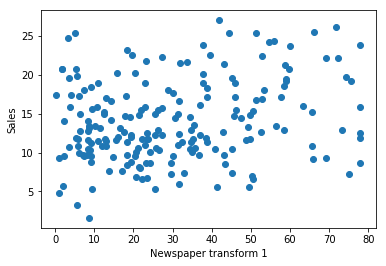

In [66]:
plt.scatter(data['Newspaper transform 1'], data['Sales'])
plt.ylabel('Sales')
plt.xlabel('Newspaper transform 1')
plt.show

x = data['Newspaper']
data['Newspaper transform 1'] =  np.where(data['Newspaper transform 1'] < 5, None, x)

data

The function scale provides a quick and easy way to perform this operation on a single array-like dataset:
>>> from sklearn import preprocessing
>>> import numpy as np
>>> X_train = np.array([[ 1., -1.,  2.],
...                     [ 2.,  0.,  0.],
...                     [ 0.,  1., -1.]])
>>> X_scaled = preprocessing.scale(X_train)

>>> X_scaled                                          
array([[ 0.  ..., -1.22...,  1.33...],
       [ 1.22...,  0.  ..., -0.26...],
       [-1.22...,  1.22..., -1.06...]])n)


Scaled data has zero mean and unit variance:
>>> X_scaled.mean(axis=0)
array([0., 0., 0.])

>>> X_scaled.std(axis=0)
array([1., 1., 1.])

<function matplotlib.pyplot.show(*args, **kw)>

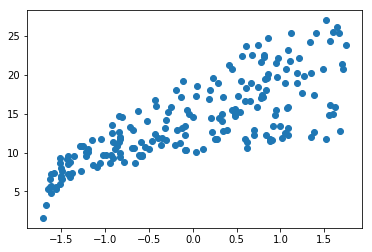

In [67]:
TV_train = data['TV']

TV_scaled = preprocessing.scale(TV_train)

data['TV Scaled'] = TV_scaled

plt.scatter(data['TV Scaled'], data['Sales'])
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

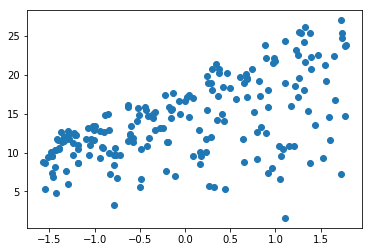

In [68]:
R_train = data['Radio']

R_scaled = preprocessing.scale(R_train)

data['Radio Scaled'] = R_scaled



plt.scatter(data['Radio Scaled'], data['Sales'])
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

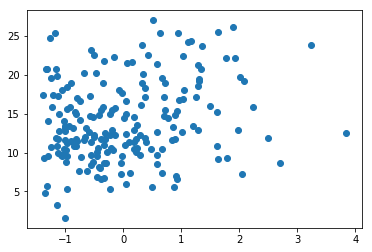

In [69]:
N_train = data['Newspaper']

N_scaled = preprocessing.scale(N_train)

data['Newspaper Scaled'] = N_scaled



plt.scatter(data['Newspaper Scaled'], data['Sales'])
plt.show

The preprocessing module further provides a utility class 
StandardScaler that implements the Transformer API to compute the mean and standard deviation 
on a training set so as to be able to later reapply the same transformation on the testing set. 
This class is hence suitable for use in the early steps of a sklearn.pipeline.Pipeline:

>>> scaler = preprocessing.StandardScaler().fit(X_train)
>>> scaler
StandardScaler(copy=True, with_mean=True, with_std=True)

>>> scaler.mean_                                      
array([1. ..., 0. ..., 0.33...])

>>> scaler.scale_                                       
array([0.81..., 0.81..., 1.24...])

>>> scaler.transform(X_train)                           
array([[ 0.  ..., -1.22...,  1.33...],
       [ 1.22...,  0.  ..., -0.26...],
       [-1.22...,  1.22..., -1.06...]])


scaler = (preprocessing.StandardScaler().fit(N_train))
scaler

In [70]:
fit_n_train = [ 69.2,  45.1,  69.3,  58.5,  58.4,  75.,   23.5,  11.6,   1.,   21.2,  24.2,   4.,
  65.9,   7.2,  46.,   52.9, 114.,   55.8,  18.3,  19.1,  53.4,  23.5,  49.6,  26.2,
  18.3,  19.5,  12.6,  22.9,  22.9,  40.8,  43.2,  38.6,  30.,    0.3,   7.4,   8.5,
   5.,   45.7,  35.1,  32.,   31.6,  38.7,   1.8,  26.4,  43.3,  31.5,  35.7,  18.5,
  49.9,  36.8,  34.6,   3.6,  39.6,  58.7,  15.9,  60.,   41.4,  16.6,  37.7,   9.3,
  21.4,  54.7,  27.3,   8.4,  28.9,   0.9,   2.2,  10.2,  11.,   27.2,  38.7,  31.7,
  19.3,  31.3,  13.1,  89.4,  20.7,  14.2,   9.4,  23.1,  22.3,  36.9,  32.5,  35.6,
  33.8,  65.7,  16.,   63.2,  73.4,  51.4,   9.3,  33.,   59.,   72.3,  10.9,  52.9,
   5.9,  22.,   51.2,  45.9,  49.8, 100.9,  21.4,  17.9,   5.3,  59.,   29.7,  23.2,
  25.6,   5.5,  56.5,  23.2,   2.4,  10.7,  34.5,  52.7,  25.6,  14.8,  79.2,  22.3,
  46.2,  50.4,  15.6,  12.4,  74.2,  25.9,  50.6,   9.2,   3.2,  43.1,   8.7,  43.,
   2.1,  45.1,  65.6,   8.5,   9.3,  59.7,  20.5,   1.7,  12.9,  75.6,  37.9,  34.4,
  38.9,   9.,    8.7,  44.3,  11.9,  20.6,  37.,   48.7,  14.2,  37.7,   9.5,   5.7,
  50.5,  24.3,  45.2,  34.6,  30.7,  49.3,  25.6,   7.4,   5.4,  84.8,  21.6,  19.4,
  57.6,   6.4,  18.4,  47.4,  17.,   12.8,  13.1,  41.8,  20.3,  35.2,  23.7,  17.6,
   8.3,  27.4,  29.7,  71.8,  30.,   19.6,  26.6,  18.2,   3.7,  23.4,   5.8,   6.,
  31.6,   3.6,   6.,   13.8,   8.1,   6.4,  66.2,   8.7]

data.insert(1, 'Fit Newspaper Scaled', fit_n_train)

In [71]:
data

,Outcome,Fit Newspaper Scaled,Feature,TV,Radio,Newspaper,Sales,Newspaper transform 1,TV Scaled,Radio Scaled,Newspaper Scaled
0,,69.200,,230.100,37.800,69.200,22.100,69.200,0.970,0.982,1.779
1,,45.100,,44.500,39.300,45.100,10.400,45.100,-1.197,1.083,0.670
2,,69.300,,17.200,45.900,69.300,9.300,69.300,-1.516,1.528,1.784
3,,58.500,,151.500,41.300,58.500,18.500,58.500,0.052,1.218,1.286
4,,58.400,,180.800,10.800,58.400,12.900,58.400,0.394,-0.842,1.282
5,,75.000,,8.700,48.900,75.000,7.200,75.000,-1.615,1.731,2.046
6,,23.500,,57.500,32.800,23.500,11.800,23.500,-1.046,0.644,-0.325
7,,11.600,,120.200,19.600,11.600,13.200,11.600,-0.313,-0.247,-0.872
8,,1.000,,8.600,2.100,1.000,4.800,1.000,-1.617,-1.429,-1.360
9,,21.200,,199.800,2.600,21.200,10.600,21.200,0.616,-1.395,-0.431


## What does Heteroscedasticity mean?
Put simply, heteroscedasticity (also spelled heteroskedasticity) refers to the circumstance in which the variability of a variable is unequal across the range of values of a second variable that predicts it.

## What are the assumptions required for linear regression?
The linearity assumption can best be tested with scatter plots, the following two examples depict two cases, where no and little linearity is present. Secondly, the linear regression analysis requires all variables to be multivariate normal. This assumption can best be checked with a histogram or a Q-Q-Plot.

## How do you find a residual?
A residual is the difference between the observed y-value (from scatter plot) and the predicted y-value (from regression equation line). It is the vertical distance from the actual plotted point to the point on the regression line.

## DSB Unit 2.4.3 Drill Problem: 
### The assumption of linearity is not met by the feature data['Newspaper']

    A scatter plot in which x = data['Newpaper'] and y = data['Sales'] revealed this.
    
### The assumption of homoscadacity is not met by the freature data['Newspaper']
    This was revealed in a histogram, and when sklearn library for scaling was applied to this varieble, and the mean was revealed as not being centered on 0.

In [72]:
# Example:  stats.boxcox(data[0,])

b = data['Newspaper']

newb = stats.boxcox(b)

In [73]:
newb

(array([11.71988913,  9.40076922, 11.72843781, 10.76001804, 10.75058538,
        12.20436177,  6.58054832,  4.28220788,  0.        ,  6.20137237,
         6.69163883,  1.8805611 , 11.43365777,  3.07326288,  9.49888373,
        10.21659728, 15.00645606, 10.50196813,  5.6874887 ,  5.8337057 ,
        10.26643557,  6.58054832,  9.88058933,  6.9991222 ,  5.6874887 ,
         5.90548258,  4.5175562 ,  6.48378929,  6.48378929,  8.91555564,
         9.18983994,  8.65577666,  7.54780384, -0.94518092,  3.1363596 ,
         3.46686338,  2.2990914 ,  9.46630369,  8.22413383,  7.82043565,
         7.76671786,  8.66776852,  0.66662525,  7.02911033,  9.20107418,
         7.75322683,  8.29984862,  5.72438525,  9.9116618 ,  8.43676401,
         8.16046236,  1.69616044,  8.77489525, 10.77885531,  5.22514967,
        10.90039937,  8.98498609,  5.36395345,  8.547029  ,  3.69189254,
         6.23526433, 10.3947609 ,  7.1624511 ,  3.43788365,  7.39334188,
        -0.10306527,  0.93455534,  3.93200132,  4.1

([array([ 4.,  9., 29., 20., 41., 33., 34., 19.,  9.,  2.]),
  array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])],
 array([-0.94518092,  0.64998278,  2.24514648,  3.84031018,  5.43547388,
         7.03063757,  8.62580127, 10.22096497, 11.81612867, 13.41129236,
        15.00645606]),
 <a list of 2 Lists of Patches objects>)

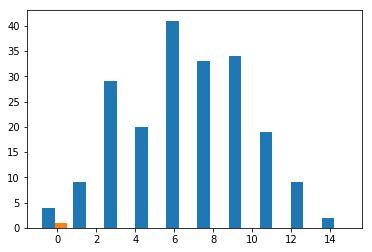

In [74]:
plt.hist(newb)

# Compute Standard Deviation
#Find the mean of the array data values
mean_value = np.mean(data_mean)

#Find the standard deviation of the array data values
standard_deviation = np.std(data_mean)

#create an array consisting of the standard deviations from the mean
array = data_mean/standard_deviation

In [75]:
#plt.hist(np.std(newb))

newb

(array([11.71988913,  9.40076922, 11.72843781, 10.76001804, 10.75058538,
        12.20436177,  6.58054832,  4.28220788,  0.        ,  6.20137237,
         6.69163883,  1.8805611 , 11.43365777,  3.07326288,  9.49888373,
        10.21659728, 15.00645606, 10.50196813,  5.6874887 ,  5.8337057 ,
        10.26643557,  6.58054832,  9.88058933,  6.9991222 ,  5.6874887 ,
         5.90548258,  4.5175562 ,  6.48378929,  6.48378929,  8.91555564,
         9.18983994,  8.65577666,  7.54780384, -0.94518092,  3.1363596 ,
         3.46686338,  2.2990914 ,  9.46630369,  8.22413383,  7.82043565,
         7.76671786,  8.66776852,  0.66662525,  7.02911033,  9.20107418,
         7.75322683,  8.29984862,  5.72438525,  9.9116618 ,  8.43676401,
         8.16046236,  1.69616044,  8.77489525, 10.77885531,  5.22514967,
        10.90039937,  8.98498609,  5.36395345,  8.547029  ,  3.69189254,
         6.23526433, 10.3947609 ,  7.1624511 ,  3.43788365,  7.39334188,
        -0.10306527,  0.93455534,  3.93200132,  4.1

In [76]:
type(newb)

tuple

## This transformation does not suite the features I am using. However, this is how to do it:
#First instantiate the Normalizer
norm = preprocessing.Normalizer()

#fit_transform() is a method in the preprocessing.Normalizer class that takes one argument. 
#fit_transform() is also a method in any of the classes that take data and do something to it, 
#such as sklearn.decomposition.PCA(), 

#Next, use the normalizer to transform data
X_norm = norm.fit_transform(X)



# Box Cox can be a good transformational normalizer for the features that show a lognormal shape when ploted on a histogram.

The Box Cox histogram of data['Newspaper'] lets us know that we should pursue it.

See the normalizer called sklearn.preprocessing.PowerTransformer(). This has two transformers, Yeo-Johnson and Box Cox. 

## Quantile Transformation normalizer:
data['TV'] and data['Radio'] have a distribution that is uniform. This histogram shape is amost a flat line.  
It should be a more or less an evenly distributed curve shaped histogram.  Using a Quantile transformation to normalize the data can be helpful in this case.

Example code:

>>> import numpy as np
>>> from sklearn.preprocessing import quantile_transform
>>> rng = np.random.RandomState(0)
>>> X = np.sort(rng.normal(loc=0.5, scale=0.25, size=(25, 1)), axis=0)
>>> quantile_transform(X, n_quantiles=10, random_state=0)
... 
array([...])

 import numpy as np
>>> from sklearn.preprocessing import quantile_transform
>>> rng = np.random.RandomState(0)
>>> X = np.sort(rng.normal(loc=0.5, scale=0.25, size=(25, 1)), axis=0)
>>> quantile_transform(X, n_quantiles=10, random_state=0)
... 
array([...])

In [77]:


#Normalize data['TV'] and data['Radio'] using sklearn's preprocessing.QuantileTransformer(random_state=0)

t = np.array(data['TV'])

rng = np.random.RandomState(0)


t = np.sort(rng.normal(loc=0.5, scale=0.25, size=(25, 1)), axis=0)

#TVQuantile = preprocessing.QuantileTransformer(T)

quantile_transform(t, n_quantiles=10, random_state=0)

array([[9.99999998e-08],
       [9.87187297e-02],
       [1.06436120e-01],
       [1.17546710e-01],
       [2.10174366e-01],
       [2.19454446e-01],
       [2.34986656e-01],
       [3.24436417e-01],
       [3.33333333e-01],
       [4.13607939e-01],
       [4.23394641e-01],
       [4.62578413e-01],
       [4.71122361e-01],
       [4.98342373e-01],
       [5.99865364e-01],
       [6.33903024e-01],
       [6.66666667e-01],
       [6.88731010e-01],
       [6.96111249e-01],
       [8.12806989e-01],
       [8.21603540e-01],
       [8.81264388e-01],
       [9.05160277e-01],
       [9.93194350e-01],
       [9.99999900e-01]])

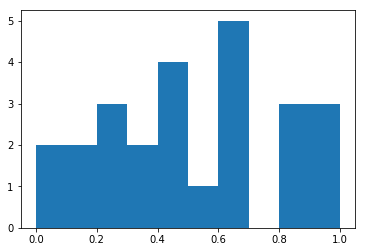

In [78]:
new_quantile_tv = quantile_transform(t, n_quantiles=10, random_state=0)
plt.hist(new_quantile_tv)
plt.show()

In [79]:
print('new_quantile_tv std: ', new_quantile_tv.std())
print('new_quantile_tv mean: ', new_quantile_tv.mean())

new_quantile_tv std:  0.2946906951601518
new_quantile_tv mean:  0.5051196622113732


#Box Cox Example:
b = data['Newspaper']

newb = stats.boxcox(b)

In [80]:
#Normalize data['Radio']

d = np.array(data['Radio'])

rng = np.random.RandomState(0)


d = np.sort(rng.normal(loc=0.5, scale=0.25, size=(25, 1)), axis=0)

#TVQuantile = preprocessing.QuantileTransformer(T)

quantile_transform(d, n_quantiles=10, random_state=0)

array([[9.99999998e-08],
       [9.87187297e-02],
       [1.06436120e-01],
       [1.17546710e-01],
       [2.10174366e-01],
       [2.19454446e-01],
       [2.34986656e-01],
       [3.24436417e-01],
       [3.33333333e-01],
       [4.13607939e-01],
       [4.23394641e-01],
       [4.62578413e-01],
       [4.71122361e-01],
       [4.98342373e-01],
       [5.99865364e-01],
       [6.33903024e-01],
       [6.66666667e-01],
       [6.88731010e-01],
       [6.96111249e-01],
       [8.12806989e-01],
       [8.21603540e-01],
       [8.81264388e-01],
       [9.05160277e-01],
       [9.93194350e-01],
       [9.99999900e-01]])

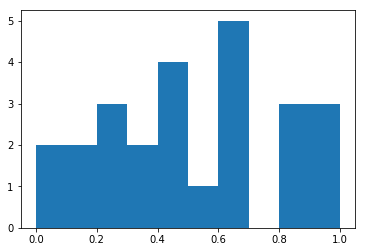

In [81]:
new_quantile_radio = quantile_transform(d, n_quantiles=10, random_state=0)
plt.hist(new_quantile_radio)
plt.show()

In [82]:
print('new_quantile_radio std: ', new_quantile_radio.std())
print('new_quantile_radio mean: ', new_quantile_radio.mean())

new_quantile_radio std:  0.2946906951601518
new_quantile_radio mean:  0.5051196622113732


>>> import numpy as np
>>> from sklearn.decomposition import PCA
>>> X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
>>> pca = PCA(n_components=2)
>>> pca.fit(X)
PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)
>>> print(pca.explained_variance_ratio_)  
[0.9924... 0.0075...]
>>> print(pca.singular_values_)  
[6.30061... 0.54980...]

In [83]:
data['TV']

0     230.100
1      44.500
2      17.200
3     151.500
4     180.800
5       8.700
6      57.500
7     120.200
8       8.600
9     199.800
10     66.100
11    214.700
12     23.800
13     97.500
14    204.100
15    195.400
16     67.800
17    281.400
18     69.200
19    147.300
20    218.400
21    237.400
22     13.200
23    228.300
24     62.300
25    262.900
26    142.900
27    240.100
28    248.800
29     70.600
        ...  
170    50.000
171   164.500
172    19.600
173   168.400
174   222.400
175   276.900
176   248.400
177   170.200
178   276.700
179   165.600
180   156.600
181   218.500
182    56.200
183   287.600
184   253.800
185   205.000
186   139.500
187   191.100
188   286.000
189    18.700
190    39.500
191    75.500
192    17.200
193   166.800
194   149.700
195    38.200
196    94.200
197   177.000
198   283.600
199   232.100
Name: TV, Length: 200, dtype: float64

In [84]:
data['Radio']

0     37.800
1     39.300
2     45.900
3     41.300
4     10.800
5     48.900
6     32.800
7     19.600
8      2.100
9      2.600
10     5.800
11    24.000
12    35.100
13     7.600
14    32.900
15    47.700
16    36.600
17    39.600
18    20.500
19    23.900
20    27.700
21     5.100
22    15.900
23    16.900
24    12.600
25     3.500
26    29.300
27    16.700
28    27.100
29    16.000
       ...  
170   11.600
171   20.900
172   20.100
173    7.100
174    3.400
175   48.900
176   30.200
177    7.800
178    2.300
179   10.000
180    2.600
181    5.400
182    5.700
183   43.000
184   21.300
185   45.100
186    2.100
187   28.700
188   13.900
189   12.100
190   41.100
191   10.800
192    4.100
193   42.000
194   35.600
195    3.700
196    4.900
197    9.300
198   42.000
199    8.600
Name: Radio, Length: 200, dtype: float64

In [85]:
data['Newspaper']

0      69.200
1      45.100
2      69.300
3      58.500
4      58.400
5      75.000
6      23.500
7      11.600
8       1.000
9      21.200
10     24.200
11      4.000
12     65.900
13      7.200
14     46.000
15     52.900
16    114.000
17     55.800
18     18.300
19     19.100
20     53.400
21     23.500
22     49.600
23     26.200
24     18.300
25     19.500
26     12.600
27     22.900
28     22.900
29     40.800
        ...  
170    18.400
171    47.400
172    17.000
173    12.800
174    13.100
175    41.800
176    20.300
177    35.200
178    23.700
179    17.600
180     8.300
181    27.400
182    29.700
183    71.800
184    30.000
185    19.600
186    26.600
187    18.200
188     3.700
189    23.400
190     5.800
191     6.000
192    31.600
193     3.600
194     6.000
195    13.800
196     8.100
197     6.400
198    66.200
199     8.700
Name: Newspaper, Length: 200, dtype: float64

In [86]:
data['Sales']

0     22.100
1     10.400
2      9.300
3     18.500
4     12.900
5      7.200
6     11.800
7     13.200
8      4.800
9     10.600
10     8.600
11    17.400
12     9.200
13     9.700
14    19.000
15    22.400
16    12.500
17    24.400
18    11.300
19    14.600
20    18.000
21    12.500
22     5.600
23    15.500
24     9.700
25    12.000
26    15.000
27    15.900
28    18.900
29    10.500
       ...  
170    8.400
171   14.500
172    7.600
173   11.700
174   11.500
175   27.000
176   20.200
177   11.700
178   11.800
179   12.600
180   10.500
181   12.200
182    8.700
183   26.200
184   17.600
185   22.600
186   10.300
187   17.300
188   15.900
189    6.700
190   10.800
191    9.900
192    5.900
193   19.600
194   17.300
195    7.600
196    9.700
197   12.800
198   25.500
199   13.400
Name: Sales, Length: 200, dtype: float64

In [87]:
#Run PCA for data['TV'] and data['Radio']

#First scale the datframe
#Example:
#X = StandardScaler().fit_transform(df_pca)

s = StandardScaler().fit_transform(X)



## Next, use PCA to transform the matrix.
#Example:
sklearn_pca = PCA(n_components=4)
Y_sklearn = sklearn_pca.fit_transform(X)

print(
    'The percentage of total variance in the dataset explained by each',
    'component from Sklearn PCA.\n',
    sklearn_pca.explained_variance_ratio_
)

## Compare the sklearn solution to ours – a perfect match.
plt.plot(Y_sklearn[:, 0], Y, 'o')
plt.title('Comparing solutions')
plt.ylabel('Sklearn Component 1')
plt.xlabel('By-hand Component 1')
plt.show()

The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [0.45695084 0.32775205 0.21529712]


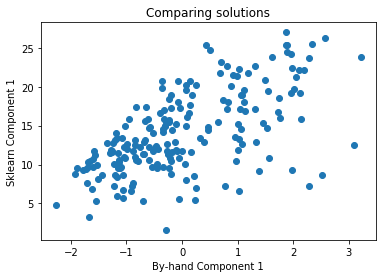

In [88]:
sklearn_pca = PCA(n_components=3)
Y_sklearn = sklearn_pca.fit_transform(s)

print(
    'The percentage of total variance in the dataset explained by each',
    'component from Sklearn PCA.\n',
    sklearn_pca.explained_variance_ratio_
)

plt.plot(Y_sklearn[:, 0], Y, 'o')
plt.title('Comparing solutions')
plt.ylabel('Sklearn Component 1')
plt.xlabel('By-hand Component 1')
plt.show()

In [89]:
print('matrix with untransformed features: ', sklearn_pca.explained_variance_ratio_)

matrix with untransformed features:  [0.45695084 0.32775205 0.21529712]


In [90]:
newb

(array([11.71988913,  9.40076922, 11.72843781, 10.76001804, 10.75058538,
        12.20436177,  6.58054832,  4.28220788,  0.        ,  6.20137237,
         6.69163883,  1.8805611 , 11.43365777,  3.07326288,  9.49888373,
        10.21659728, 15.00645606, 10.50196813,  5.6874887 ,  5.8337057 ,
        10.26643557,  6.58054832,  9.88058933,  6.9991222 ,  5.6874887 ,
         5.90548258,  4.5175562 ,  6.48378929,  6.48378929,  8.91555564,
         9.18983994,  8.65577666,  7.54780384, -0.94518092,  3.1363596 ,
         3.46686338,  2.2990914 ,  9.46630369,  8.22413383,  7.82043565,
         7.76671786,  8.66776852,  0.66662525,  7.02911033,  9.20107418,
         7.75322683,  8.29984862,  5.72438525,  9.9116618 ,  8.43676401,
         8.16046236,  1.69616044,  8.77489525, 10.77885531,  5.22514967,
        10.90039937,  8.98498609,  5.36395345,  8.547029  ,  3.69189254,
         6.23526433, 10.3947609 ,  7.1624511 ,  3.43788365,  7.39334188,
        -0.10306527,  0.93455534,  3.93200132,  4.1

In [91]:
o = StandardScaler().fit_transform(new_quantile_radio, new_quantile_tv, newb)

TypeError: fit_transform() takes from 2 to 3 positional arguments but 4 were given

In [ ]:
sklearn_pca = PCA(n_components=3)
Y_sklearn = sklearn_pca.fit_transform(t)

print(
    'The percentage of total variance in the dataset explained by each',
    'component from Sklearn PCA.\n',
    sklearn_pca.explained_variance_ratio_
)

plt.plot(Y_sklearn[:, 0], Y, 'o')
plt.title('Comparing solutions')
plt.ylabel('Sklearn Component 1')
plt.xlabel('By-hand Component 1')
plt.show()